In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("dark")
plt.style.use('ggplot')

from sklearn.metrics import classification_report
import json

## 1. Load data from train

In [9]:
from sqlalchemy import create_engine

engine = create_engine('sqlite:///../data/data.db', echo=True)
conn = engine.connect()

df = pd.read_sql("SELECT * FROM train",conn)

2021-04-25 11:00:35,002 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2021-04-25 11:00:35,013 INFO sqlalchemy.engine.base.Engine ()
2021-04-25 11:00:35,019 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2021-04-25 11:00:35,020 INFO sqlalchemy.engine.base.Engine ()
2021-04-25 11:00:35,024 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("SELECT * FROM train")
2021-04-25 11:00:35,025 INFO sqlalchemy.engine.base.Engine ()
2021-04-25 11:00:35,027 INFO sqlalchemy.engine.base.Engine PRAGMA temp.table_info("SELECT * FROM train")
2021-04-25 11:00:35,029 INFO sqlalchemy.engine.base.Engine ()
2021-04-25 11:00:35,031 INFO sqlalchemy.engine.base.Engine SELECT * FROM train
2021-04-25 11:00:35,033 INFO sqlalchemy.engine.base.Engine ()


In [10]:
df.shape

(5698, 3)

In [11]:
df.label.value_counts()

824.company-brand.general-satisfaction.0                   2682
824.account-management.account-access.0                     847
824.company-brand.convenience.0                             799
824.online-experience.updates-versions.0                    565
824.company-brand.competitor.0                              520
824.account-management.fingerprint-facial-recognition.0     199
824.staff-support.agent-named.0                              32
824.staff-support.email.0                                    17
824.online-experience.language.0                             13
824.purchase-booking-experience.choice-variety.0             11
824.logistics-rides.speed.0                                   6
824.attributes.size-fit.0                                     3
824.logistics-rides.order-accuracy.0                          2
824.attributes.taste-flavour.0                                1
824.attributes.cleanliness.0                                  1
Name: label, dtype: int64

In [12]:
## remove the label < 20 posts
df = df[~df['label'].isin([
                      '824.staff-support.email.0',
                      '824.online-experience.language.0',
                      '824.purchase-booking-experience.choice-variety.0',
                      '824.logistics-rides.speed.0',
                      '824.attributes.size-fit.0',
                      '824.logistics-rides.order-accuracy.0',
                      '824.attributes.taste-flavour.0',
                      '824.attributes.cleanliness.0'])]

In [13]:
label_df = pd.merge(df['comment'],pd.get_dummies(df['label']),left_index=True, right_index=True)

In [14]:
print("Label number:", len(label_df.drop('comment',axis=1).columns))

Label number: 7


## 2. train-val split

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
train, val = train_test_split(label_df,test_size=0.1,random_state=101)

In [17]:
train.shape, val.shape

((5079, 8), (565, 8))

## 3. Model Comparison

### 3.2 W2V + LSTM

In [18]:
import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

2.4.1


In [19]:
def label_class(y):
    if y>0.5:
        return 1
    else:
        return 0

In [20]:
## tokenization

vocab_size = 5000
embedding_dim = 32
max_length = 200 ## from eda, we know most of posts having the token number less than 200
trunc_type = 'post'
oov_toc = "<OOV>"


In [21]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_toc)
tokenizer.fit_on_texts(train['comment'])
word_index = tokenizer.word_index

In [85]:
with open("../models/w2v/token_config.json","w") as tk:
    json.dump(tokenizer.to_json(),tk)

In [22]:
train_sequences = tokenizer.texts_to_sequences(train['comment'])
train_padded = pad_sequences(train_sequences,maxlen=max_length, truncating=trunc_type)

In [23]:
test_sequences = tokenizer.texts_to_sequences(val['comment'])
test_padded = pad_sequences(test_sequences,maxlen=max_length)

In [24]:
train_padded.shape, test_padded.shape

((5079, 200), (565, 200))

In [25]:
train_labels = train.drop('comment',axis=1) 
train_labels.fillna(0,inplace=True)
train_labels = train_labels.values
train_labels.shape

(5079, 7)

In [19]:
## Create W2V embedding

In [20]:
input_layer = Input(shape=(max_length,),name='input')
x = Embedding(vocab_size, embedding_dim, input_length=max_length)(input_layer)
x = Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True))(x)
x = Bidirectional(tf.keras.layers.LSTM(32))(x)
x = Dense(32,activation='relu')(x)
x = Dense(16,activation = 'relu')(x)

out1 = tf.keras.layers.Dense(1, activation='sigmoid',name = 'out1')(x)
out2 = tf.keras.layers.Dense(1, activation='sigmoid',name = 'out2')(x)
out3 = tf.keras.layers.Dense(1, activation='sigmoid',name = 'out3')(x)
out4 = tf.keras.layers.Dense(1, activation='sigmoid',name = 'out4')(x)
out5 = tf.keras.layers.Dense(1, activation='sigmoid',name = 'out5')(x)
out6 = tf.keras.layers.Dense(1, activation='sigmoid',name = 'out6')(x)
out7 = tf.keras.layers.Dense(1, activation='sigmoid',name = 'out7')(x)



multitask_model = Model(inputs=input_layer, outputs=[out1,out2,out3,out4,out5,out6,out7])

In [21]:
multitask_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 32)      160000      input[0][0]                      
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 200, 128)     49664       embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 64)           41216       bidirectional[0][0]              
______________________________________________________________________________________________

In [22]:
multitask_model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(),metrics=tf.metrics.AUC())

In [23]:
ylabel = {'out'+str(i):train.iloc[:,i].values for i in range(1,8)}

In [24]:
hist = multitask_model.fit(x=train_padded,
                    y=ylabel,
                    epochs=10, 
                    validation_split=0.1,
                    batch_size=32,
                    workers=8,
                    verbose=1
                    )

Epoch 1/10
143/143 [==============================] - 30s 162ms/step - loss: 3.0797 - out1_loss: 0.5143 - out2_loss: 0.2617 - out3_loss: 0.4269 - out4_loss: 0.4786 - out5_loss: 0.7104 - out6_loss: 0.4357 - out7_loss: 0.2520 - out1_auc: 0.5131 - out2_auc: 0.4906 - out3_auc: 0.4985 - out4_auc: 0.5145 - out5_auc: 0.5016 - out6_auc: 0.5059 - out7_auc: 0.4342 - val_loss: 2.2729 - val_out1_loss: 0.3867 - val_out2_loss: 0.1578 - val_out3_loss: 0.2680 - val_out4_loss: 0.4219 - val_out5_loss: 0.6893 - val_out6_loss: 0.3095 - val_out7_loss: 0.0397 - val_out1_auc: 0.8298 - val_out2_auc: 0.7972 - val_out3_auc: 0.4782 - val_out4_auc: 0.4719 - val_out5_auc: 0.7560 - val_out6_auc: 0.7610 - val_out7_auc: 0.5119
Epoch 2/10
143/143 [==============================] - 20s 142ms/step - loss: 2.2346 - out1_loss: 0.3911 - out2_loss: 0.1260 - out3_loss: 0.3249 - out4_loss: 0.4080 - out5_loss: 0.6366 - out6_loss: 0.2982 - out7_loss: 0.0497 - out1_auc: 0.7546 - out2_auc: 0.7564 - out3_auc: 0.4270 - out4_auc: 0.

In [25]:
## Visualization
hist.history.keys()

dict_keys(['loss', 'out1_loss', 'out2_loss', 'out3_loss', 'out4_loss', 'out5_loss', 'out6_loss', 'out7_loss', 'out1_auc', 'out2_auc', 'out3_auc', 'out4_auc', 'out5_auc', 'out6_auc', 'out7_auc', 'val_loss', 'val_out1_loss', 'val_out2_loss', 'val_out3_loss', 'val_out4_loss', 'val_out5_loss', 'val_out6_loss', 'val_out7_loss', 'val_out1_auc', 'val_out2_auc', 'val_out3_auc', 'val_out4_auc', 'val_out5_auc', 'val_out6_auc', 'val_out7_auc'])

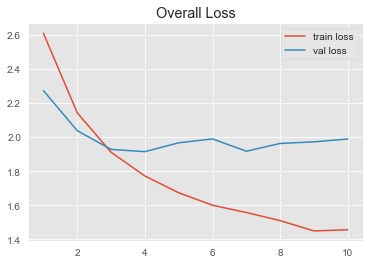

In [26]:
plt.title('Overall Loss')
plt.plot(range(1,11),hist.history['loss'])
plt.plot(range(1,11),hist.history['val_loss'])

plt.legend(['train loss','val loss'])

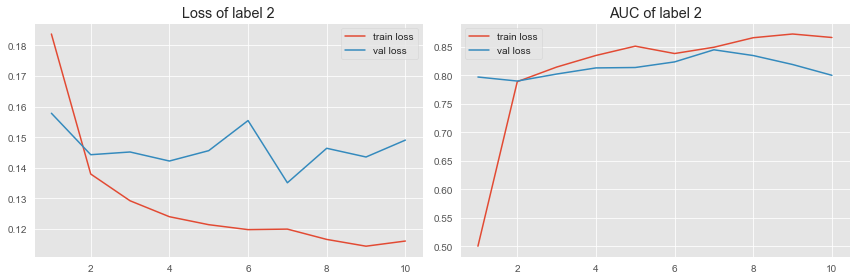

In [27]:
def plot_loss_and_auc(label_no):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    axes[0].plot(range(1,11),hist.history['out'+str(label_no)+'_loss'])
    axes[0].plot(range(1,11),hist.history['val_out'+str(label_no)+'_loss'])
    axes[0].set_title(f'Loss of label {label_no}')
    axes[0].legend(['train loss','val loss'])
    axes[1].plot(range(1,11),hist.history['out'+str(label_no)+'_auc'])
    axes[1].plot(range(1,11),hist.history['val_out'+str(label_no)+'_auc'])
    axes[1].set_title(f'AUC of label {label_no}')
    axes[1].legend(['train loss','val loss'])
    fig.tight_layout()
    

plot_loss_and_auc(2)

In [ ]:
## prediction

In [28]:
prediction2 = multitask_model.predict(test_padded)
prediction2 = [[label_class(i) for i in p] for p in prediction2]
prediction2 = pd.DataFrame(prediction2).transpose()

In [29]:
print("Unweighted output:\n", classification_report(val.drop('comment',axis=1).values,
                                                    prediction2,
                                                   target_names=val.drop('comment',axis=1).columns)
     )

Unweighted output:
                                                          precision    recall  f1-score   support

                824.account-management.account-access.0       0.50      0.33      0.39        95
824.account-management.fingerprint-facial-recognition.0       0.00      0.00      0.00        14
                         824.company-brand.competitor.0       0.00      0.00      0.00        68
                        824.company-brand.convenience.0       0.40      0.06      0.10        72
               824.company-brand.general-satisfaction.0       0.73      0.75      0.74       269
               824.online-experience.updates-versions.0       0.00      0.00      0.00        44
                        824.staff-support.agent-named.0       0.00      0.00      0.00         3

                                              micro avg       0.68      0.42      0.52       565
                                              macro avg       0.23      0.16      0.18       565
        

/Users/szuyaochien/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/szuyaochien/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
multitask_model.save('../models/w2v/model')

INFO:tensorflow:Assets written to: ../models/w2v/model/assets


INFO:tensorflow:Assets written to: ../models/w2v/model/assets


In [ ]:
## weighted class 

In [38]:
from sklearn.utils.class_weight import compute_class_weight
yweights = {'out'+str(i): compute_class_weight('balanced',np.unique(train.iloc[:,i].values), train.iloc[:,i].values) for i in range(1,8)}

In [39]:
yweights_dict = {i: {0:yweights[i][0],1:yweights[i][1]} for i in yweights}
print("balance class weights:\n",yweights_dict)

balance class weights:
 {'out1': {0: 0.5868962329558586, 1: 3.376994680851064}, 'out2': {0: 0.5189006947282386, 1: 13.727027027027027}, 'out3': {0: 0.5488437432461638, 1: 5.618362831858407}, 'out4': {0: 0.5835248161764706, 1: 3.4931224209078406}, 'out5': {0: 0.9525506376594148, 1: 1.0524243680066308}, 'out6': {0: 0.5571522597630539, 1: 4.8742802303262955}, 'out7': {0: 0.5028712871287129, 1: 87.56896551724138}}


In [40]:
## tensorflow does not support multioutput class_weight like Keras used to do :(((( !
multitask_model.fit(x=train_padded,
                    y=ylabel,
                    epochs=10,
                    validation_split=0.1,
                    batch_size=32,
                    class_weight=yweights_dict
                    ) 

ValueError: Expected `class_weight` to be a dict with keys from 0 to one less than the number of classes, found {'out1': {0: 0.5868962329558586, 1: 3.376994680851064}, 'out2': {0: 0.5189006947282386, 1: 13.727027027027027}, 'out3': {0: 0.5488437432461638, 1: 5.618362831858407}, 'out4': {0: 0.5835248161764706, 1: 3.4931224209078406}, 'out5': {0: 0.9525506376594148, 1: 1.0524243680066308}, 'out6': {0: 0.5571522597630539, 1: 4.8742802303262955}, 'out7': {0: 0.5028712871287129, 1: 87.56896551724138}}